# COURSEWORK 2 : Neural Style Transfer

I have been fascinated by the intersection of art and technology and the concept of neural style transfer caught my attention while learning about deep learning. It allows anyone to create unique images by blending the content of one and the style of another together. 

This method of creating images -or "art" for some people- has been a hot topic in the field of computer vision and has started a lot of debate about whether it really is art or not. 

That's why I have decided to learn about this method, since I myself draw to gain an opinion on the subject and see how far this model can go. 

Workflow

>1.   Prepare the data
2.   Define the model 
3.   Beat commonsense baseline 
4.   Tweak 
5.   Evaluate







In [20]:
#Imports
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg16
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display
import numpy as np

### Prepare the data
First, we need to upload our content and style images. To do so, we make use of the upload function from google.colab to directly upload the files into the colab files. 


In [ ]:
from google.colab import files
uploaded = files.upload()

Helper Functions

In [21]:
#load image 
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = tf.keras.preprocessing.image.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
    return im_array

#functions to plot images
def show_file(img,title=None):
  img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
  plt.imshow(np.uint8(img))
  if title is None:
    pass
  else:
    plt.title(title)
    plt.imshow(np.uint8(img))

def show_images(img1_path, img2_path, title1=None, title2=None):
  img1 = load_file(img1_path)
  img2 = load_file(img2_path) 
  plt.figure(figsize=(6,6))
  plt.subplot(1,2,1) #row,col,index
  show_file(img1, title1)
  plt.subplot(1,2,2)
  show_file(img2, title2)
  plt.show()

Now let's get the path of our images. And let's take a look at our images. 

I didn't choose the easiest style image, it is quite subtle and looks mostly realistic except that brush strokes are more visible and so on but I wanted to see what was neural style transfer capable of with less obvious style images.

In [22]:
#style_path = keras.utils.get_file("sam_yang_asset.jpg", origin="file:/content/img/sam-yang-asset.jpg")
#content_path = keras.utils.get_file("portrait.jpg", origin="file:/content/img/portrait.jpg")
style_path = "/content/img/sam-yang-asset.jpg"
content_path = "/content/img/portrait.jpg"

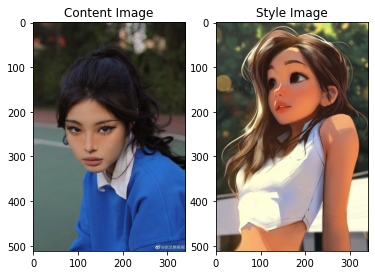

In [23]:
img1 = load_file(content_path)
img2 = load_file(style_path) 
plt.figure(figsize=(6,6))
plt.subplot(1,2,1) #row,col,index
show_file(img1, "Content Image")
plt.subplot(1,2,2)
show_file(img2, "Style Image")
plt.show()

###Pre-trained Model: VGG19 Network

To create our model, we will use the pre-trained VGG19 Network. The advantage of using such a model is that it's been trained on a large dataset of images (ImageNet) meaning that it has learned to recognise a wide variety of images and their features. It works well as a feature extractor for the neural style transfer task. 

We need functions to preprocess our images before feeding them into the VGG19 network. 

In [24]:
def get_model():
  vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
  vgg.trainable=False
  content_output=[vgg.get_layer(layer).output for layer in content_layers]
  style_output=[vgg.get_layer(layer).output for layer in style_layers]
  model_output= style_output+content_output
  return tf.keras.models.Model(vgg.input,model_output)

In [25]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [26]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg16.preprocess_input(image)
    return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [8]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

### Loss Function & Metrics

####Content Loss

The content loss measures the difference between the content of the original image and the generated image. It's calculated with the activation of a specific layer (the block5_conv2 layer) in the VGG19 model, which represents the image's content. This will help to not diverge from the original content image. 

In [27]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

####Style Loss
To calculate the style loss function, we compare the style of the content image to the style of the style image using the Gram matrix of each feature map. It's calculated using a list of layers going from low-level layers(more general shapes) to high-level layers (more precise details). 



In [10]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

####Final Loss
This is a weighted average of the two losses added together. We then try to minimise it. 

The content-weight will need to be adjusted to reach the result desired, a higher content-weight will mean that the generated image will be closer to the target content and vice versa.  

There is no total variation loss with this model since, from my understanding, the uniformity of the image is achieved differently by using noise.

In [28]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

####Gradient-descent process
The gradient-descent process is also used to minimize the loss by optimizer the parameters of the neural style transfer model between the features of the generated, content and style images. 

In [29]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

We will use the ADAM Optimizer. Sadly, when trying the code from Chollet, all my images would come out the same and I didn't know what I was doing wrong, so I looked for a different neural style transfer which would use the Adam optimizer. Since this model uses noise similarly to how the variation loss worked in the model referenced by Chollet, from what I understand, the learning-rate schedule didn't work here. 

In [13]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

### Beat commonsense baseline
To beat a common-sense baseline in neural style transfer is a bit different from the previous deep learning models that we faced. For example, for the IMDB problem, the baseline to beat was 50% since a review could either be positive or positive. Instead, here, we could, for example, overlay the content image with the style image using alpha blending and compare the output of our model with that image. Our model will easily create a better output since it will extract the style of the image more effectively and seamlessly.

After doing some research, it seems that the "conv4_2 layer" (which is the block4_conv2 layer in the VGG-19 Network) is quite effective at capturing high-level style information, such as textures and patterns. The "conv4_2 layer" is in the middle of the network, which means it captures both low and high level features. Let's use that to beat a baseline.

Let's use the weight values provided to us by the model.

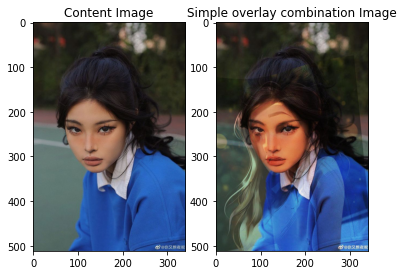

In [30]:
baseline_combination_path = keras.utils.get_file("portraitoverlay.jpg", origin="file:/content/img/portraitoverlay.jpg")

img1 = load_file(content_path)
img2 = load_file(baseline_combination_path) 
plt.figure(figsize=(6,6))
plt.subplot(1,2,1) #row,col,index
show_file(img1, "Content Image")
plt.subplot(1,2,2)
show_file(img2, "Simple overlay combination Image")
plt.show()

In [31]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block4_conv2'] 
number_content=len(content_layers)
number_style =len(style_layers)

In [32]:
model=get_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

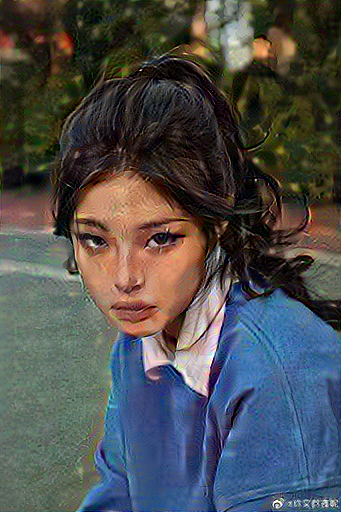

Epoch: 395
Total loss: 3.5452e+04, style loss: 2.4632e+04, content loss: 1.0821e+04, 


In [33]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=400)  

We start to see some influence from the style image but not enough features are transferred, our image still looks quite similar from the content image so let's push it a bit furter with more style layers.

###1st model
###A bigger model: more style layers (1st model)
Content weight = 1000

Style weight = 0.01

In [43]:
content_layers3 = ['block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1', 
                'block5_conv1',
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


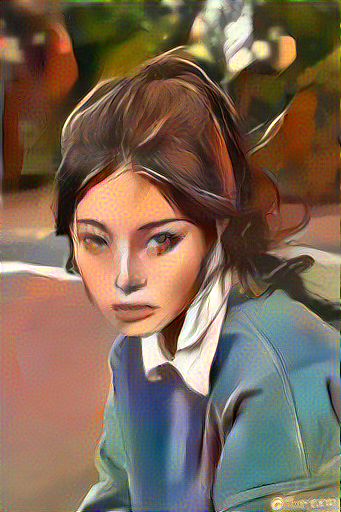

Epoch: 495
Total loss: 1.0388e+05, style loss: 6.5810e+04, content loss: 3.8072e+04, 


In [44]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

It's starting to look more like a painting similarly to the style image, but we do lose a bit of detail from the content image. 

The outcome looks very special and intriguing. I want to see what would happen if we add more content layers as well. 

Let's compare the losses: 

| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04


Our total loss has decreased which is good but we could still push the model further. 


###2nd model
###An even bigger model: add content layers (2nd model)
I wanted to see what would adding more content layers would do to our combination image and to the losses.

In [45]:
content_layers3 = ['block4_conv3','block5_conv1','block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block4_conv2', 
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


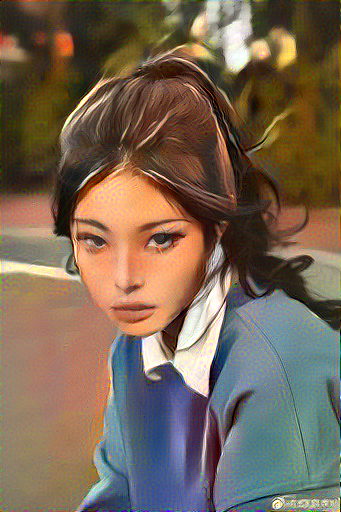

Epoch: 495
Total loss: 3.4897e+05, style loss: 1.7486e+05, content loss: 1.7411e+05, 


In [46]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

The combination image is now more similar to our base image but the loss has overall increased. It is common to use 1 or 2 layers only for the content layers (one for the low level details and one for the higher details) so I decided to bring down the amount of content layers back to 1 for now. 
Let's try to adjust the weights to see what happens. 

-

| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05

###3rd model
###Come back to our 1st model: adjust the weights
Content weight = 100

Style weight = 0.1

In [47]:
content_layers3 = ['block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1', 
                'block5_conv1',
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e2, style_weight=1e-1):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


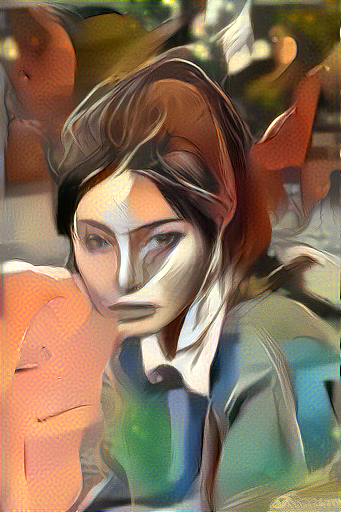

Epoch: 495
Total loss: 3.1924e+05, style loss: 2.7467e+05, content loss: 4.4569e+04, 


In [48]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

We get some really interesting results. In the combination image, we notice way more paint stroke and way less details from the base image. Even though this is quite a nice outcome, let's try to bring back some details into our final image.

The overal loss is quite stable but let's try to bring it down.


-


| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05
| 3 | 3.1924e+05 | 2.7467e+05 | 4.4569e+04
 

###4th model
###Come back to our 1st model: adjust the weights (2nd time)

Since our content loss has increased, I decided to bring up our content weight and down the style weight to see what would happen. 

Content weight = 500

Style weight = 0.05

In [49]:
content_layers3 = ['block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1', 
                'block5_conv1',
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=5e2, style_weight=5e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


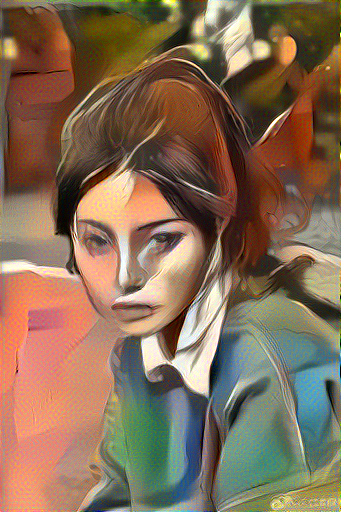

Epoch: 395
Total loss: 3.1033e+05, style loss: 2.2056e+05, content loss: 8.9772e+04, 


In [50]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=400)

| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05
| 3 | 3.1924e+05 | 2.7467e+05 | 4.4569e+04
| 4 | 3.1033e+05 | 2.2056e+05 | 8.9772e+04

Our content loss this time is quite high so I didn't think we were going in the right direction with this model. Tough it only depends on which outcome we want to achieve. Our overal loss is still not decreasing much so let's try again. 

###5th model
###Come back to our 1st model: adjust the weights (3rd time), delete a style layer and run for more epochs

Since we were still losing quite a bit from the base image, I decided not to use one of the deeper style layers to lose less details on the combination image. I also decided to run for more epochs this time. 

Content weight = 1000

Style weight = 0.02

In [58]:
content_layers3 = ['block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1', 
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=2e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


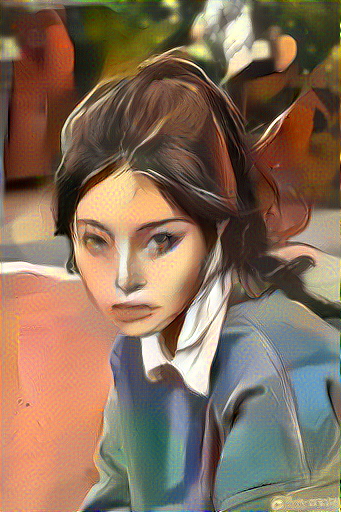

Epoch: 695
Total loss: 1.4616e+05, style loss: 8.7607e+04, content loss: 5.8556e+04, 


In [59]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=700)

| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05
| 3 | 3.1924e+05 | 2.7467e+05 | 4.4569e+04
| 4 | 3.1033e+05 | 2.2056e+05 | 8.9772e+04
| 5 | 1.4616e+05 | 8.7607e+04 | 5.8556e+04

Our total loss with this model is lower than all previous model apart from the 1st model. The combination image loses details but is still way more detailed than our previous combination image. It also shows off a bit of the style image even though it's not an obvious style but we see some sort of paint strokes and similar colour combination. 

###6th model
###Last adjustement: we keep our previous model but we add a lower-level layer to our content layers 

Content weight = 1000

Style weight = 0.02

In [62]:
content_layers3 = ['block3_conv1','block5_conv2']
style_layers3 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1', 
                ]
number_content=len(content_layers3)
number_style =len(style_layers3)

def get_model():
    
    vgg=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers3]
    style_output=[vgg.get_layer(layer).output for layer in style_layers3]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=2e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

model=get_model()
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,354,880
Trainable params: 0
Non-trainable params: 12,354,880
_________________________________________________________________


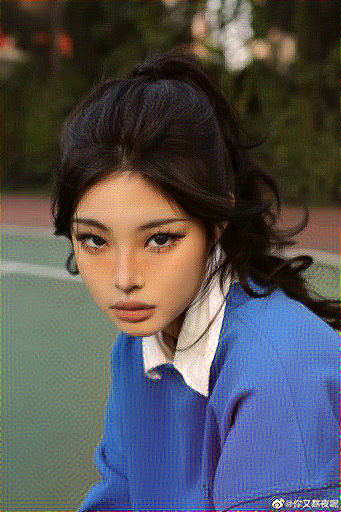

Epoch: 695
Total loss: 9.6824e+06, style loss: 6.3147e+06, content loss: 3.3677e+06, 


In [63]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=700)

| Model | Total Loss | Style Loss | Content Loss
| --- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05
| 3 | 3.1924e+05 | 2.7467e+05 | 4.4569e+04
| 4 | 3.1033e+05 | 2.2056e+05 | 8.9772e+04
| 5 | 1.4616e+05 | 8.7607e+04 | 5.8556e+04
| 6 | 9.6824e+06 | 6.3147e+06 | 3.3677e+06

All of the losses have fairly increased, the combination image barely shows off the style so this did not work at all. 

###Conclusion 
From my perspective, the 5th model did the best job at translating the style into the content image while keeping quite a fair amount of details. 

This process was quite interesting and it is amazing how many different images can be generated and how different they can look from each other by adjusting some variables like which layers to use and the weight values. 

I wish I could have used the schedule learning rate with the SGD optimizer but that did not seem to work with this model. 

| Model | Total Loss | Style Loss | Content Loss | Conclusion
| --- | :--- | :--- | :--- | :--- |
| Base | 3.5452e+04 | 2.4632e+04 | 1.0821e+04 | Not enough features are transferred
| 1 | 1.0388e+05 | 6.5810e+04 | 3.8072e+04 | More of the style is visible but we lose some of the details
| 2 | 3.4897e+05 | 1.7486e+05 | 1.7411e+05 | The style is less present 
| 3 | 3.1924e+05 | 2.7467e+05 | 4.4569e+04 | Style very pronounced
| 4 | 3.1033e+05 | 2.2056e+05 | 8.9772e+04 | Style very pronounced
| 5 | 1.4616e+05 | 8.7607e+04 | 5.8556e+04 | Good balance of style and content visible in the generated image 
| 6 | 9.6824e+06 | 6.3147e+06 | 3.3677e+06 | Style completely lost 

###References 
*   Content image: https://www.pinterest.com/pin/469922542380122594/  
*   Style image: https://analisa.io/profile/samdoesarts/post/2627887778004211390 
*   CHOLLET, Francois (2021) Deep learning with python, 2nd Edition, Manning
*   WENGER, Jeremie (2022), Artificial Intelligence Notebooks, Goldsmiths, University of London
*   SAYAK (2020), Neural Style Transfer using VGG19: 

    https://www.kaggle.com/code/sayakdasgupta/neural-style-transfer-using-vgg19/notebook 